## Remember to use MOU conda environment

In [1]:
# numpy and scipy
import numpy as np
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio
import scipy.stats as stats

# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#statistical tests
import scipy.stats as stats

#importing ENIGMA
from enigmatoolbox.datasets import load_sc_as_one
from nilearn import plotting

In [2]:
data_dir = './' # data repo
res_dir = './' # results
graph_format = 'png' # graph formatting

conds = ['CTR', 'SCZ'] #conditions
 # number of conditions

# 68 is the number of brain regions
N = 68 # size of network for DK-68 

In [3]:

sc_sctx, sc_sctx_labels = load_sc_as_one()

# Plot subcortico-cortical connectivity matrices
#sc_plot = plotting.plot_matrix(sc_sctx, figure=(9, 9), labels=sc_sctx_labels, vmax=10, vmin=0, cmap='Blues')

SC = sc_sctx[0:68,0:68]

In [4]:
#NB: ./ = prendi il path
ts_ctr = sio.loadmat('./ts_ctr.mat')['ts_ctr'] 
ts_ctr=ts_ctr[0:68,:,20:68]
ts_scz = sio.loadmat('./ts_scz.mat')['ts_scz']
ts_scz=ts_scz[0:68]
ts_all = np.stack((ts_ctr, ts_scz), axis=-1)

ts_all.shape
#68 = brain regions
#48 = patients
#152 = time (?)
#2 = ctr, scz = conditions

(68, 152, 48, 2)

In [5]:
ts_ctr.shape #same as ts_scz

(68, 152, 48)

From the graph below I can compute the two EMPIRICAL CORRELATION MATRICES:

S(0) = correlation between different brain regions at the same time t

S(1) = correlation between different brain regions with time shift t, t'

From these two I can compute B and D for each patient


Text(0.5, 1.0, 'The different curves represent the different 68 brain regions')

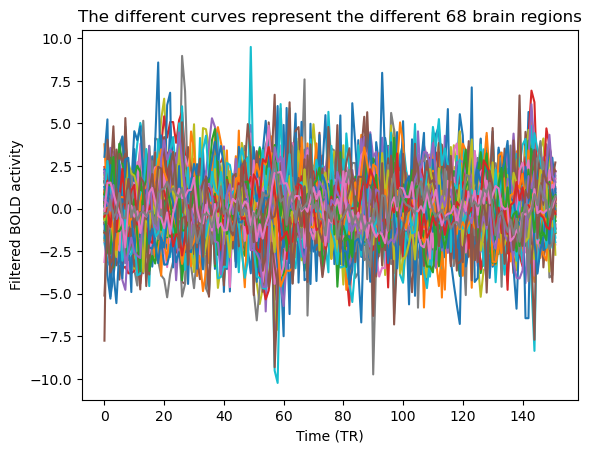

In [6]:
#important brain signals -> capisci bene come cono fatti e come sono calcolate s(0) e s(1)
plt.plot(ts_all[:,:,18,1].T)
plt.xlabel('Time (TR)')  
plt.ylabel('Filtered BOLD activity')  
plt.title('The different curves represent the different 68 brain regions') 

## ??? 
On the y-axis I can see the Brain activity: what is the filtering?

In [7]:
# BOLD broadband filtering
n_order = 2
TR = 2.0 # in seconds

Nyquist_freq = 0.5 / TR # Nyquist frequency
low_f = 0.001 / Nyquist_freq # lower cutoff for bandpass filter
high_f = 0.01  / Nyquist_freq # upper cutoff for bandpass filter
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')

# lags (in TR): 0 and 1
v_lag = np.arange(2,dtype=float)
n_lag = v_lag.size

# calc example FC for single subj
ts = sio.loadmat(data_dir+'ts_ctr.mat')['ts_ctr']
#ts = sio.loadmat('./ts_ctr.mat')['ts_ctr']
ts=ts[:, :,1]
filt_ts = spsg.filtfilt(b,a,ts,axis=1)
FC0 = np.tensordot(filt_ts[:,:-1], filt_ts[:,:-1], axes=(1,1)) / 150
FC1 = np.tensordot(filt_ts[:,:-1], filt_ts[:,1:], axes=(1,1)) / 150

## Visual test of data 

In particular for order of ROIs for 2 hemispheres...

Creates the MASK: not interesting for the first part of the analysis

I could implement something using a different mask : CONNECTOME/ ANATOMICAL

!!! Do some research on anatomical

## ??? 
I didn't understand why I could use the connectome if it represents connectivity for sleeping patients and I have data on awake patients

In [8]:
# create topological mask for AAL90
#SC = sio.loadmat('/Users/rodrigo/Desktop/Postdoc-Codes/ENIGMA-master/sc_ctx.mat')['sc_ctx'] 
SC=SC/np.max(SC)
lim_SC = 0.0 # limit DTI value to determine SC (only connections with larger values are tuned)

# anatomy-derived mask for existing connections for EC
mask_ECS = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_ECS[SC>lim_SC] = True
for i in range(N):
    mask_ECS[i,i] = True # no self connection
    mask_ECS[i,N-1-i] = False # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_ECS.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0


np.save(res_dir+'mask_ECS.npy',mask_ECS)
np.save(res_dir+'mask_Sigma.npy',mask_Sigma)

network size: 68
EC density: 0.31957857769973663


In [9]:
ts3=ts_all[0:68, :,18,0]
filt_ts = spsg.filtfilt(b,a,ts3,axis=1)
ts=stats.zscore(ts3, axis=1)
        
FC0 = np.tensordot(ts[:,:-1], ts[:,:-1], axes=(1,1)) / 149
FC1 = np.tensordot(ts[:,:-1], ts[:,1:], axes=(1,1)) / 149
FC0N=abs(FC0)/np.max(abs(FC0))
FC1N=abs(FC1)/np.max(abs(FC1))
        
lim_FC0= np.percentile(FC0N, 90)
lim_FC1= np.percentile(FC1N, 60)

# anatomy-derived mask for existing connections for EC
mask_EC1 = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC1[FC0N>lim_FC0] = True
for i in range(N):
    mask_EC1[i,i] = True # no self connection
    
mask_ECF= mask_EC1 

print('network size:', N)
print('EC density:', mask_ECF.sum()/float(N*(N-1)))

network size: 68
EC density: 0.10140474100087796


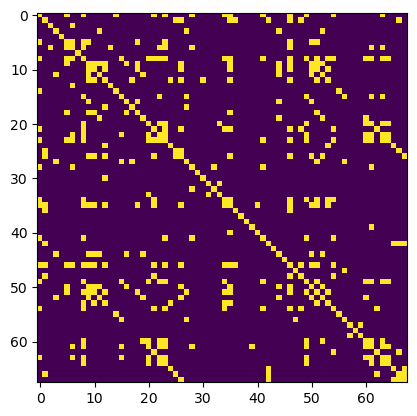

In [10]:
plt.imshow(mask_ECF)

# Model optimization

In [11]:
#GRADIENT DESCENT PART. OPTIMIZATION OF GRADIENT DESCENT 
ts3.shape,ts_all.shape

((68, 152), (68, 152, 48, 2))

In [21]:
# data and model parameters
subjects = np.arange(1, 48)
n_sub = len(subjects)
N = 68

mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

min_val_EC = 0. # maximal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC)
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model 
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)

#0.008-0.09 Hz
#0.008 to 0.08 Hz

n_order = 3
TR = 2 # in seconds
Nyquist_freq = 0.5 / TR # Nyquist frequency
low_f = 0.001 / Nyquist_freq # lower cutoff for bandpass filter
high_f = 0.01 / Nyquist_freq # upper cutoff for bandpass filter
b,a = spsg.iirfilter(n_order,[low_f,high_f],btype='bandpass',ftype='butter')


# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time serie
        ts3=ts_all[0:68, :,i_sub,i_cond]
        filt_ts = spsg.filtfilt(b,a,ts3,axis=1)
        ts=stats.zscore(ts3, axis=1)       #mask_EC=mask_ECS
        
        # store empirical BOLD variance
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
            #mask_EC=mask_ECS
        FC0 = np.tensordot(ts[:,:-1], ts[:,:-1], axes=(1,1)) / 149
        FC1 = np.tensordot(ts[:,:-1], ts[:,1:], axes=(1,1)) / 149
        FC0N=abs(FC0)/np.max(abs(FC0))
        FC1N=abs(FC1)/np.max(abs(FC1))
        
        lim_FC0= np.percentile(FC0N, 60)
        lim_FC1= np.percentile(FC1N, 50)

        # anatomy-derived mask for existing connections for EC
        mask_EC1 = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_EC1[FC0N>lim_FC0] = True
        for i in range(N):
            mask_EC1[i,i] = True # no self connection
            
        
        mask_EC2 = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_EC2[abs(FC1N)>lim_FC1] = True
        for i in range(N):
            mask_EC2[i,i] = False # no self connection
            
        mask_EC = np.zeros([N,N],dtype=bool)
    
        #types of MASKS: 
        mask_EC=mask_EC1 
        
        # invert model
        mou_est = MOUv2()
        mou_est.fit(ts.T, mask_C=mask_EC, mask_Sigma=mask_Sigma, algo_version='true', min_iter=100, epsilon_C=0.005, epsilon_Sigma=0.005) #, verbose=True)

        # store results
        J_mod[i_sub,i_cond,:,:] = mou_est.J
        Sigma_mod[i_sub,i_cond,:,:] = mou_est.Sigma
        FC0_mod[i_sub,i_cond,:,:] = spl.solve_lyapunov(J_mod[i_sub,i_cond,:,:].T, -Sigma_mod[i_sub,i_cond,:,:])
        err_mod[i_sub,i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub,i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)

#%% save results
np.save(res_dir+'J_mod.npy',J_mod)
np.save(res_dir+'Sigma_mod.npy',Sigma_mod)
np.save(res_dir+'FC0_mod.npy',FC0_mod)

np.save(res_dir+'err_mod.npy',err_mod)
np.save(res_dir+'fit_mod.npy',fit_mod)

np.save(res_dir+'var_BOLD.npy',var_BOLD)


sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 102, 'distance': np.float64(0.8263846976046748), 'correlation': np.float64(0.6126626758696172), 'distance history': array([0.91124857, 0.9096467 , 0.908065  , ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.38559493, 0.390444  , 0.39522471, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.7915192265540267), 'distFC1': np.float64(0.8908861037483862)}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 102, 'distance': np.float64(0.8631425082024318), 'correlation': np.float64(0.5920919039604694), 'distance history': array([0.91644941, 0.91267437, 0.90939334, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.37261965, 0.40114792, 0.42650856, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(34.98408504053056), 'distFC1': np.float64(6271.177967793665)}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations': 102, 'distance': np.float64(0.8469836647151427),

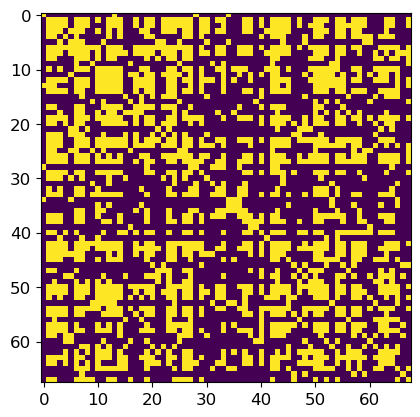

In [30]:
plt.imshow(mask_EC1)

## FC0 = 60

## Check goodness of fit : 

/tmp/ipykernel_62239/2573013235.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_62239/2573013235.py:16: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_62239/2573013235.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_62239/2573013235.py:39: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)


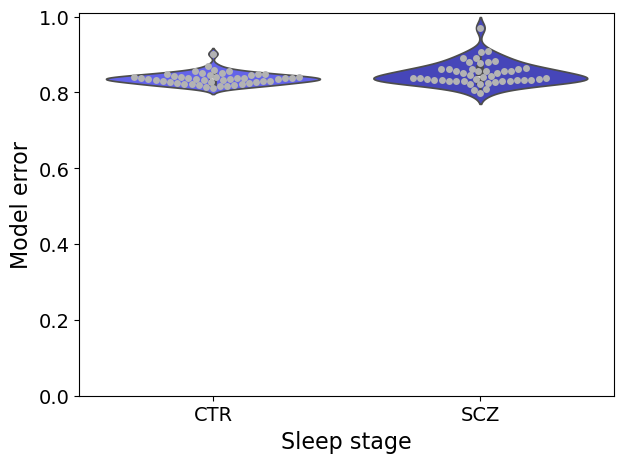

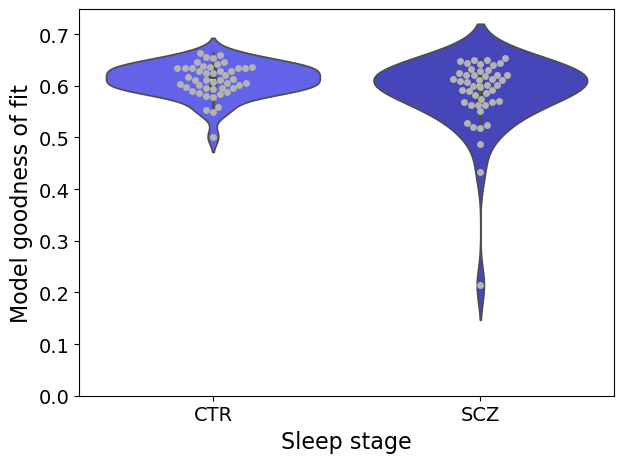

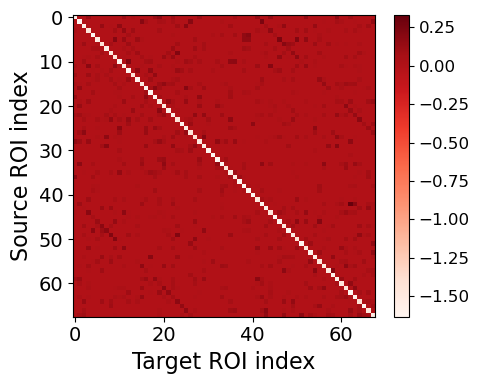

In [22]:
mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements
n_cond=2

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error #err_mod

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)

plt.figure()
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'model_fit_error.eps', format='eps')


# Pearson corr #fit_mod

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)

plt.figure()
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(res_dir+'model_goodness_fit.eps', format='eps')


# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(J_mod[18,1,:,:],0), cmap='Reds')
plt.imshow(J_mod[18,1,:,:], cmap='Reds')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(res_dir+'example_EC.eps', format='eps')

## ENTROPY CALCULATION

In [23]:

# transpose to Saclay's framework
EPR = np.zeros([n_sub,n_cond])
Q_indiv = np.zeros([n_sub,n_cond,N,N])

for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        try:
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T)
            D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:])
            S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
            Q = np.dot(B, S) - D
            Q_indiv[i_sub,i_cond,:,:] = Q
            
            # sanity check
            if True:
                print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
            
            # formula from Godreche Luck
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))
            EPR[i_sub,i_cond] = entropy_prod_rate

        except:
            print('problem with subject/cond:', i_sub, i_cond)

should be close to zero: 7.338747665119882e-15
should be close to zero: 2.7533531010703882e-14
should be close to zero: 4.440892098500626e-15
should be close to zero: 2.7533531010703882e-14
should be close to zero: 1.7763568394002505e-14
should be close to zero: 1.865174681370263e-14
should be close to zero: 8.659739592076221e-15
should be close to zero: 1.1546319456101628e-14
should be close to zero: 2.7804147872956264e-14
should be close to zero: 5.995204332975845e-15
should be close to zero: 5.5593550596366725e-15
should be close to zero: 9.325873406851315e-15
should be close to zero: 9.769962616701378e-15
should be close to zero: 1.021405182655144e-14
should be close to zero: 1.1102230246251565e-14
should be close to zero: 9.325873406851315e-15
should be close to zero: 4.884981308350689e-15
should be close to zero: 4.707345624410664e-14
should be close to zero: 1.8207657603852567e-14
should be close to zero: 9.325873406851315e-15
should be close to zero: 7.549516567451064e-15
shoul

should be close to zero: 4.440892098500626e-15
should be close to zero: 3.552713678800501e-14
should be close to zero: 7.993605777301127e-15
should be close to zero: 1.0658141036401503e-14
should be close to zero: 5.773159728050814e-15
should be close to zero: 1.021405182655144e-14
should be close to zero: 1.0658141036401503e-14
should be close to zero: 7.993605777301127e-15
should be close to zero: 1.021405182655144e-14
should be close to zero: 1.509903313490213e-14
should be close to zero: 1.021405182655144e-14
should be close to zero: 2.1316282072803006e-14
should be close to zero: 8.43769498715119e-15
should be close to zero: 7.993605777301127e-15
should be close to zero: 1.7319479184152442e-14
should be close to zero: 4.440892098500626e-14
should be close to zero: 9.103828801926284e-15
should be close to zero: 2.3092638912203256e-14
should be close to zero: 1.9539925233402755e-14
should be close to zero: 3.197442310920451e-14
should be close to zero: 1.021405182655144e-14
should b

/tmp/ipykernel_62239/2923277758.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
/tmp/ipykernel_62239/2923277758.py:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)


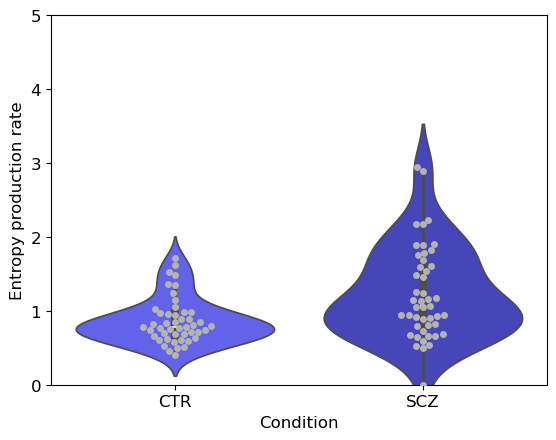

In [24]:

#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)


# real data

plt.figure()
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=5)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy production rate', fontsize=12)

plt.savefig(res_dir+'entropy_prod_rate.eps', format='eps')

In [25]:
EPR_df

,sleep stage,EPR
0,CTR,0.890368
1,SCZ,1.609589
2,CTR,0.665221
3,SCZ,2.948995
4,CTR,1.348923
...,...,...
89,SCZ,0.528455
90,CTR,0.516013
91,SCZ,0.801393
92,CTR,0.965509


Verify that the two groups are 
## Statistically Different

1. Check for normality of data distribution: SHAPIRO TEST

In [26]:

CTR = EPR[:,0]
SCZ = EPR[:,1]

stat_ctr, p_ctr = stats.shapiro(CTR)
stat_scz, p_scz = stats.shapiro(SCZ)

print(f"CTR: Test statistic = {stat_ctr:.3f}, p-value = {p_ctr:.3f}")
print(f"SCZ: Test statistic = {stat_scz:.3f}, p-value = {p_scz:.3f}")

if p_ctr > 0.05:
    print("CTR data is likely normally distributed")
else:
    print("CTR data is not normally distributed")

if p_scz > 0.05:
    print("SCZ data is likely normally distributed")
else:
    print("SCZ data is not normally distributed")


CTR: Test statistic = 0.900, p-value = 0.001
SCZ: Test statistic = 0.939, p-value = 0.017
CTR data is not normally distributed
SCZ data is not normally distributed


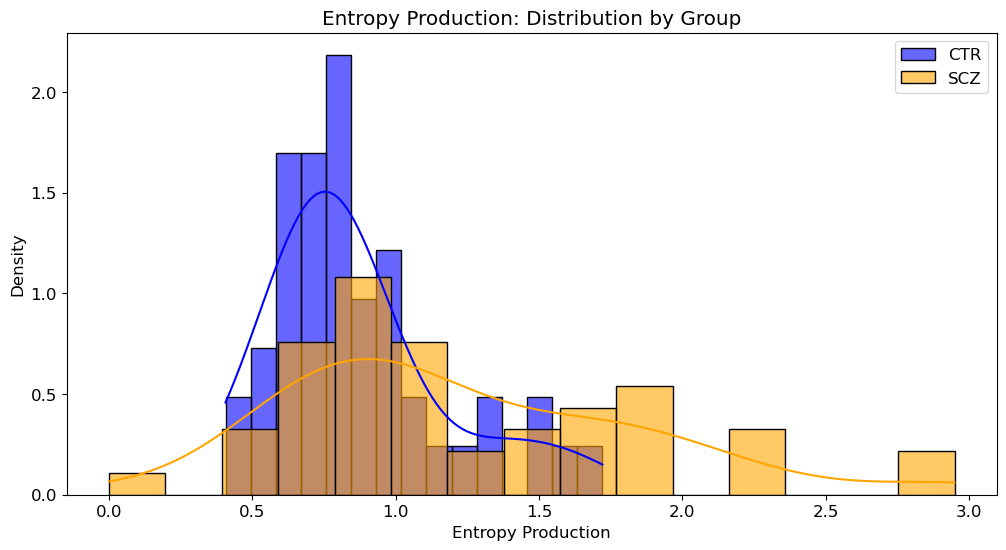

In [27]:
# Plotting histograms with KDE

plt.figure(figsize=(12, 6))

sb.histplot(CTR, kde=True, color='blue', label='CTR', bins=15, stat='density', alpha=0.6)
sb.histplot(SCZ, kde=True, color='orange', label='SCZ', bins=15, stat='density', alpha=0.6)

plt.title('Entropy Production: Distribution by Group')
plt.xlabel('Entropy Production')
plt.ylabel('Density')
plt.legend()
plt.show()

2. Check Variance Homogneity: LEVENE'S TEST

In [28]:

stat_var, p_var = stats.levene(CTR, SCZ)

print(f"Levene's Test statistic: {stat_var:.3f}, p-value: {p_var:.3f}")

if p_var > 0.05:
    print("Variances are likely equal.")
else:
    print("Variances are not equal.")

Levene's Test statistic: 13.786, p-value: 0.000
Variances are not equal.


3. Check if the two groups are statistically different: WELCH TEST

In [29]:

stat_t, p_t = stats.ttest_ind(CTR, SCZ, equal_var=False)

print(f"Welch's t-test statistic: {stat_t:.3f}, p-value: {p_t:.3f}")

if p_t < 0.05:
    print("The difference between groups is statistically significant.")
else:
    print("No significant difference between groups.")

Welch's t-test statistic: -3.667, p-value: 0.000
The difference between groups is statistically significant.
